In [14]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from shutil import copyfile
import matplotlib.pyplot as plt

# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

epoch_count = 50

In [15]:
# Define paths
# base_dir = '/content/drive/MyDrive/FireRisk'
base_dir = 'FireRisk'
train_dir = os.path.join(base_dir, 'train')

In [16]:
def stratified_split(directory, test_size=0.2, val_size=0.2, seed=42):
    """Fast stratified split without file copying"""
    # First get all file paths and their labels
    file_paths = []
    labels = []
    class_names = sorted(os.listdir(directory))

    for label_idx, class_name in enumerate(class_names):
        class_dir = os.path.join(directory, class_name)
        class_files = [os.path.join(class_dir, f)
                      for f in os.listdir(class_dir)
                      if f.endswith(('.jpg', '.jpeg', '.png'))]
        file_paths.extend(class_files)
        labels.extend([label_idx] * len(class_files))

    # Convert to numpy arrays
    file_paths = np.array(file_paths)
    labels = np.array(labels)

    # split into train/val/test
    X = np.array(file_paths)
    y = np.array(labels)

    # First split into train+val and test
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, stratify=y, random_state=seed)

    # Then split train+val into train and val
    val_size_adjusted = val_size / (1 - test_size)  # Adjust for previous split
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_size_adjusted,
        stratify=y_train_val, random_state=seed)

    return (X_train, y_train), (X_val, y_val), (X_test, y_test)

In [17]:
(X_train, y_train), (X_val, y_val), (X_test, y_test) = stratified_split(train_dir)

In [18]:
def create_dataset(file_paths, labels, class_names, img_size=(150, 150), batch_size=32, shuffle=True):
    """Create a TensorFlow dataset from file paths and labels"""
    # Convert labels to one-hot encoding
    labels = tf.keras.utils.to_categorical(labels, num_classes=len(class_names))

    # Create dataset from file paths
    ds = tf.data.Dataset.from_tensor_slices((file_paths, labels))

    def load_and_preprocess_image(path, label):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, img_size)
        image = image / 255.0  # Normalize to [0,1]
        return image, label

    if shuffle:
        ds = ds.shuffle(buffer_size=len(file_paths))

    ds = ds.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)

    return ds

In [19]:
img_size = (150, 150)
batch_size = 32
class_names = sorted(os.listdir(train_dir))

In [20]:
train_ds = create_dataset(X_train, y_train, class_names, img_size, batch_size, shuffle=True)
val_ds = create_dataset(X_val, y_val, class_names, img_size, batch_size, shuffle=False)
test_ds = create_dataset(X_test, y_test, class_names, img_size, batch_size, shuffle=False)

In [21]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal"),
#     tf.keras.layers.RandomRotation(0.1),
#     tf.keras.layers.RandomZoom(0.1),
# ])
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
])

In [22]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y),
    num_parallel_calls=tf.data.AUTOTUNE)

In [23]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(class_names), activation='softmax')
])

/mnt/e/projects/climate/.venv/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [25]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', save_best_only=True),
    tf.keras.callbacks.TerminateOnNaN()
]

In [26]:
history = model.fit(
    train_ds,
    #validation_data=val_ds,
    validation_data=None,
    epochs=epoch_count,
    callbacks=callbacks,
    verbose=1)

Epoch 1/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 28s 20ms/step - accuracy: 0.3845 - loss: 1.5467
Epoch 2/50
   3/1319 ━━━━━━━━━━━━━━━━━━━━ 36s 28ms/step - accuracy: 0.4427 - loss: 1.3526  

/mnt/e/projects/climate/.venv/lib/python3.12/site-packages/keras/src/callbacks/model_checkpoint.py:209: UserWarning: Can save best model only with val_loss available, skipping.
  self._save_model(epoch=epoch, batch=None, logs=logs)


1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.4606 - loss: 1.3422
Epoch 3/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.4810 - loss: 1.2894
Epoch 4/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.4877 - loss: 1.2701
Epoch 5/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5006 - loss: 1.2385
Epoch 6/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.4967 - loss: 1.2426
Epoch 7/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5032 - loss: 1.2305
Epoch 8/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 26s 20ms/step - accuracy: 0.5047 - loss: 1.2265
Epoch 9/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5032 - loss: 1.2278
Epoch 10/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.5138 - loss: 1.2097
Epoch 11/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 21ms/step - accuracy: 0.5170 - loss: 1.2010
Epoch 12/50
1319/1319 ━━━━━━━━━━━━━━━━━━━━ 27s 20ms/step - accuracy: 0.5115 - loss: 1.2060
Epoch 13/50
1319/1

In [27]:
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test accuracy: {test_acc:.4f}')

438/440 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.5225 - loss: 1.2338

2025-05-11 19:46:35.797530: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_94', 4 bytes spill stores, 4 bytes spill loads



440/440 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.5225 - loss: 1.2338
Test accuracy: 0.5199


2025-05-11 19:46:36.446177: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step


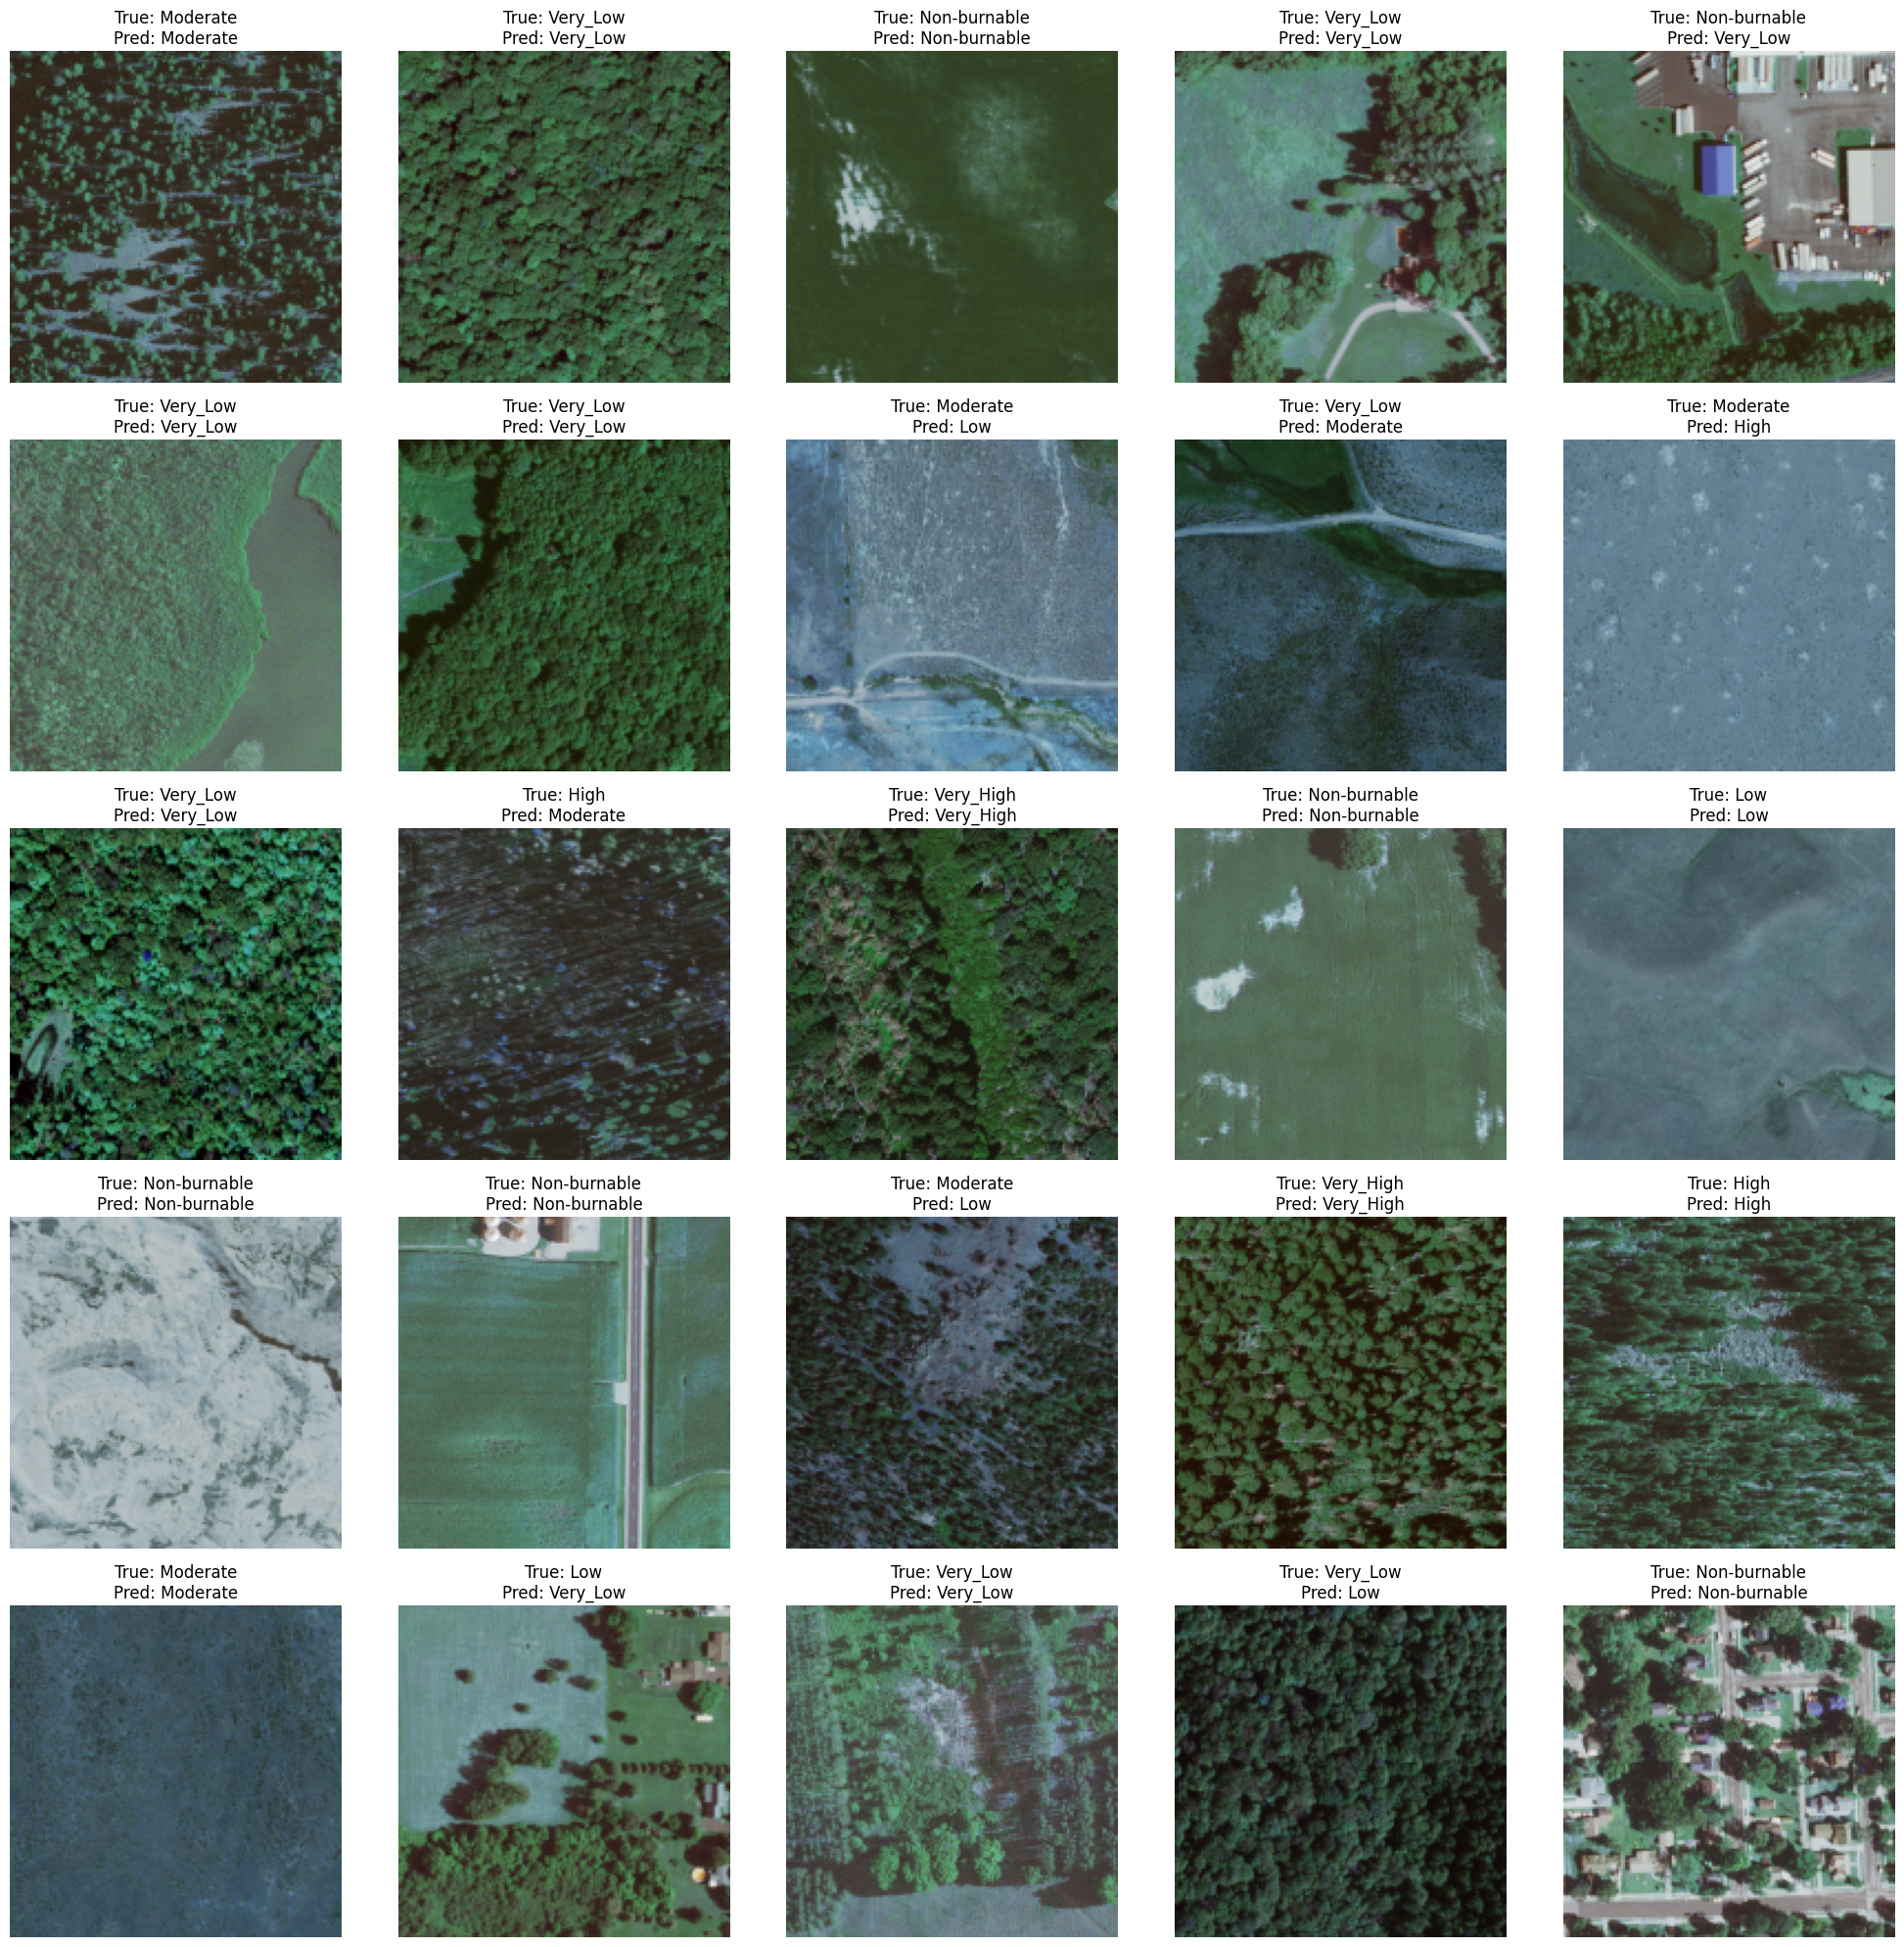

In [28]:
import random

# Get test images and labels (already preprocessed by test_ds)
test_images = []
test_labels = []
for images, labels in test_ds.take(1):  # Take one batch
    test_images = images.numpy()
    test_labels = labels.numpy()

# Get predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(test_labels, axis=1)

# Select 5 random indices
random_indices = random.sample(range(len(test_images)), 25)

# Display the images with predictions
plt.figure(figsize=(20, 20))
for i, idx in enumerate(random_indices):
    plt.subplot(5, 5, i+1)
    plt.imshow(test_images[idx])
    plt.title(f"True: {class_names[true_classes[idx]]}\nPred: {class_names[predicted_classes[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()

100%|██████████| 440/440 [00:28<00:00, 15.28it/s]


Classes present in evaluation: [0 1 2 3 4 5 6]

Classification Report:
              precision    recall  f1-score   support

        High     0.3778    0.3129    0.3423      1259
         Low     0.2993    0.2611    0.2789      2141
    Moderate     0.3028    0.2681    0.2844      1723
Non-burnable     0.6934    0.7642    0.7271      3592
   Very_High     0.3445    0.2523    0.2913       654
    Very_Low     0.5668    0.6422    0.6022      4352
       Water     0.7433    0.5607    0.6392       346

    accuracy                         0.5199     14067
   macro avg     0.4754    0.4374    0.4522     14067
weighted avg     0.5031    0.5199    0.5091     14067


Per-class Accuracy:
High           : 31.29% (394/1259)
Low            : 26.11% (559/2141)
Moderate       : 26.81% (462/1723)
Non-burnable   : 76.42% (2745/3592)
Very_High      : 25.23% (165/654)
Very_Low       : 64.22% (2795/4352)
Water          : 56.07% (194/346)


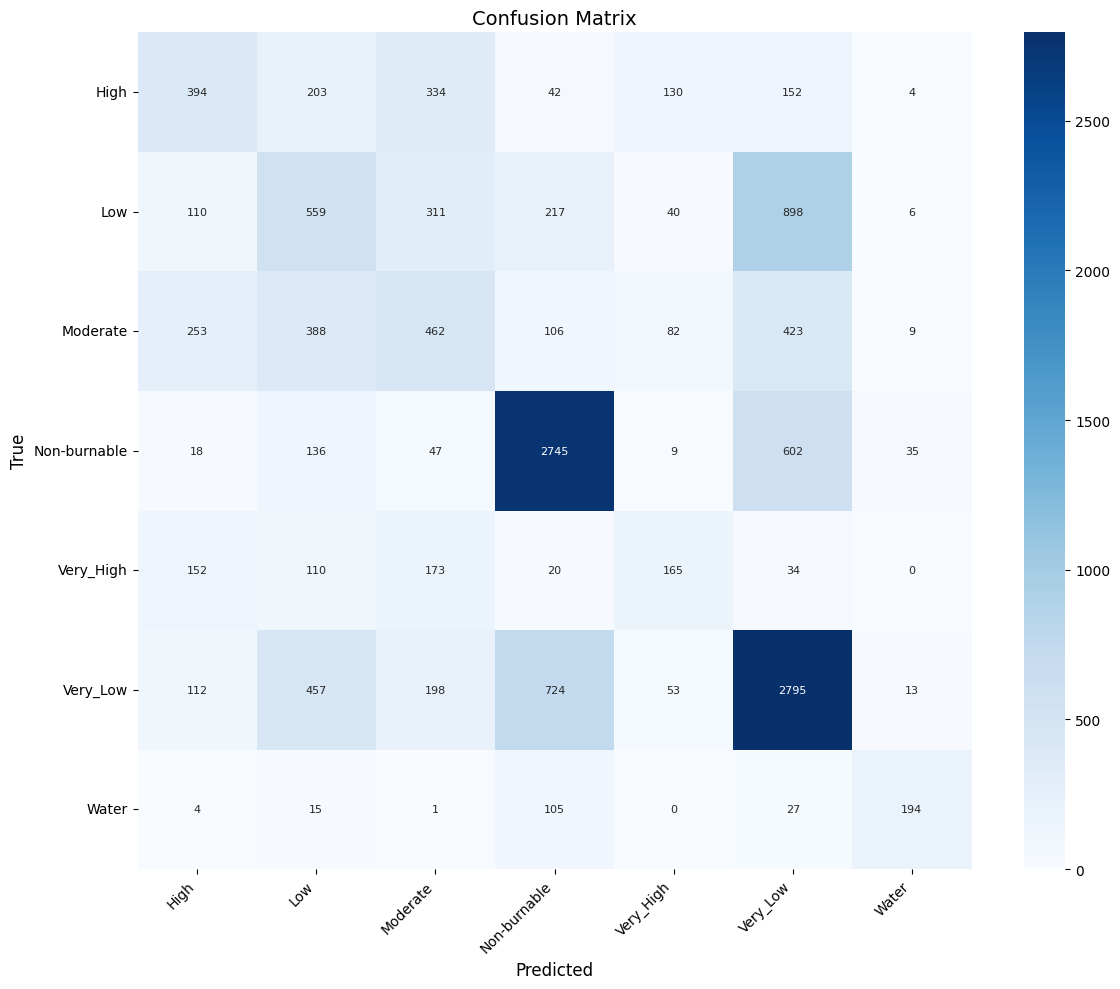

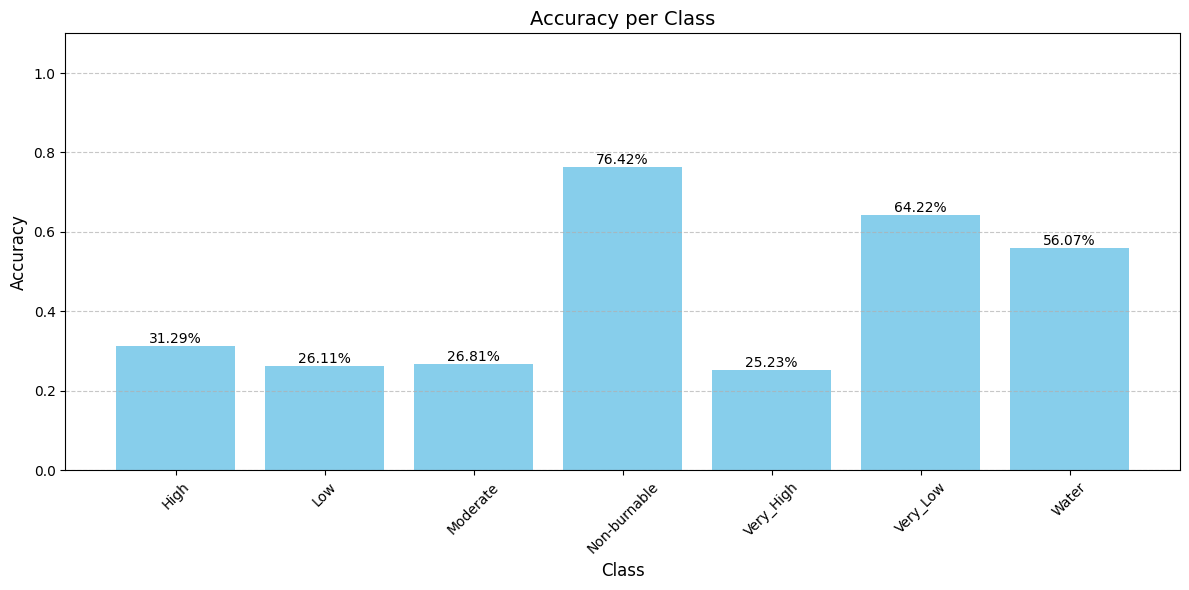


Additional Metrics:
Overall Accuracy: 51.99%
Balanced Accuracy: 43.74%


In [29]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
from tqdm import tqdm

# Get all test predictions and true labels
all_true = []
all_pred = []

for images, labels in tqdm(test_ds):
    # Convert labels from one-hot if needed
    if labels.ndim > 1:
        true_labels = np.argmax(labels.numpy(), axis=1)
    else:
        true_labels = labels.numpy()

    # Get predictions
    preds = model.predict(images, verbose=0)
    pred_classes = np.argmax(preds, axis=1)

    all_true.extend(true_labels)
    all_pred.extend(pred_classes)

# Convert to numpy arrays
all_true = np.array(all_true)
all_pred = np.array(all_pred)

# Find actually present classes
present_classes = np.unique(np.concatenate([all_true, all_pred]))
print(f"Classes present in evaluation: {present_classes}")

# Create filtered class names
filtered_class_names = [class_names[i] for i in present_classes]

# 1. Classification Report
print("\nClassification Report:")
print(classification_report(
    all_true,
    all_pred,
    labels=present_classes,
    target_names=filtered_class_names,
    digits=4
))

# 2. Per-class accuracy
conf_mat = confusion_matrix(all_true, all_pred, labels=present_classes)
class_accuracies = conf_mat.diagonal() / conf_mat.sum(axis=1)

print("\nPer-class Accuracy:")
for i, class_idx in enumerate(present_classes):
    print(f"{class_names[class_idx]:<15}: {class_accuracies[i]:.2%} ({conf_mat[i,i]}/{conf_mat.sum(axis=1)[i]})")

# 3. Confusion Matrix Visualization
plt.figure(figsize=(12, 10))
sns.heatmap(
    conf_mat,
    annot=True,
    fmt='d',
    xticklabels=filtered_class_names,
    yticklabels=filtered_class_names,
    cmap='Blues',
    annot_kws={'size': 8}
)
plt.title('Confusion Matrix', fontsize=14)
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('True', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# 4. Class-wise Performance Bar Plot
plt.figure(figsize=(12, 6))
bars = plt.bar(filtered_class_names, class_accuracies, color='skyblue')

# Add exact values on top of bars
for bar, acc in zip(bars, class_accuracies):
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{acc:.2%}',
             ha='center', va='bottom')

plt.title('Accuracy per Class', fontsize=14)
plt.xlabel('Class', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.ylim(0, 1.1)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# 5. Additional Metrics
print("\nAdditional Metrics:")
print(f"Overall Accuracy: {np.mean(all_true == all_pred):.2%}")
print(f"Balanced Accuracy: {np.mean(class_accuracies):.2%}")

# Model using ResNet

In [30]:
# import tensorflow as tf
# from tensorflow.keras import layers, models, applications, callbacks, optimizers
# import matplotlib.pyplot as plt
# def create_resnet_model(num_classes=7):
#     # Load pre-trained ResNet50 with custom head
#     base_model = applications.ResNet50V2(
#         weights='imagenet',
#         include_top=False,
#         input_shape=(150,150,3),
#         pooling='avg'  # Replaces need for GlobalAveragePooling
#     )

#     # Freeze base layers initially
#     base_model.trainable = False

#     # Custom classification head
#     inputs = layers.Input(shape=(150,150,3))
#     x = applications.resnet_v2.preprocess_input(inputs)
#     x = base_model(x)
#     x = layers.Dense(512, activation='relu')(x)
#     x = layers.Dropout(0.3)(x)
#     outputs = layers.Dense(num_classes, activation='softmax')(x)

#     model = models.Model(inputs, outputs)

#     # Compile with lower initial LR
#     model.compile(
#         optimizer=optimizers.Adam(0.0001),
#         loss='categorical_crossentropy',
#         metrics=['accuracy',
#                 tf.keras.metrics.Precision(name='precision'),
#                 tf.keras.metrics.Recall(name='recall')]
#     )

#     return model

# model_res = create_resnet_model()

In [31]:
# training_callbacks = [
#     callbacks.ModelCheckpoint(
#         'best_model.h5',
#         monitor='val_accuracy',
#         save_best_only=True,
#         mode='max'
#     ),
#     callbacks.EarlyStopping(
#         monitor='val_accuracy',
#         patience=15,
#         restore_best_weights=True
#     ),
#     callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.5,
#         patience=5,
#         verbose=1
#     ),
#     callbacks.TensorBoard(log_dir='./logs')
# ]

# # 4. Training Process (2-phase)
# print("Phase 1: Training head only")
# history1 = model_res.fit(
#     train_ds,
#     validation_data=None,
#     epochs=10,
#     callbacks=training_callbacks,
#     verbose=1
# )

In [32]:
# print("\nPhase 2: Fine-tuning full model")
# # Unfreeze deeper layers
# model_res.get_layer('resnet50v2').trainable = True
# for layer in model_res.get_layer('resnet50v2').layers[:100]:
#     layer.trainable = False  # Keep early layers frozen

# # Recompile with lower LR
# model_res.compile(
#     optimizer=optimizers.Adam(0.00001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# history2 = model_res.fit(
#     train_ds,
#     validation_data=val_ds,
#     epochs=20,
#     callbacks=training_callbacks,
#     verbose=1
# )

In [33]:
# print("\nFinal Evaluation:")
# test_results = model_res.evaluate(test_ds)
# print(f"Test Accuracy: {test_results[1]:.2%}")
# print(f"Test Precision: {test_results[2]:.2%}")
# print(f"Test Recall: {test_results[3]:.2%}")

In [34]:
# def plot_history(history):
#     plt.figure(figsize=(12,4))
#     plt.subplot(1,2,1)
#     plt.plot(history.history['accuracy'], label='Train')
#     plt.plot(history.history['val_accuracy'], label='Validation')
#     plt.title('Accuracy')
#     plt.legend()

#     plt.subplot(1,2,2)
#     plt.plot(history.history['loss'], label='Train')
#     plt.plot(history.history['val_loss'], label='Validation')
#     plt.title('Loss')
#     plt.legend()
#     plt.show()

# plot_history(history1)
# plot_history(history2)